In [1]:
import pandas as pd
import os.path as op
import retro
from src.features.annotations import generate_key_events, generate_aps_events, plot_bidsevents
from src.features.features import compute_framewise_aps
import matplotlib.pyplot as plt
from src.params import figures_path


def retrieve_variables(files):
    '''
    files : list of files with complete path

    variable_lists : dictionnary (each variable is an entry) containing list of arrays of
    length corresponding to the number of frames in each run,
    with runs ordered by timestamp.
    '''

    variables_lists = {}

    for file in files:
        level = file[-11:-8]
        timestamp = file[-73:-65]
        print(file)
        if level == '5-0':
            env = retro.make('ShinobiIIIReturnOfTheNinjaMaster-Genesis', state='Level5')
        else:
            env = retro.make('ShinobiIIIReturnOfTheNinjaMaster-Genesis', state='Level'+level)
        actions = env.buttons

        run_variables = {}
        key_log = retro.Movie(file)
        env.reset()
        run_completed = False
        while key_log.step():
            a = [key_log.get_key(i, 0) for i in range(env.num_buttons)]
            _,_,done,i = env.step(a)

            if variables_lists == {}: # init final dict
                variables_lists['filename'] = []
                variables_lists['timestamp'] = []
                variables_lists['level'] = []
                for action in actions:
                    variables_lists[action] = []
                for variable in i.keys():
                    variables_lists[variable] = []

            if run_variables == {}: # init temp dict
                for variable in i.keys():
                    run_variables[variable] = []
                for action in actions:
                    run_variables[action] = []

            for variable in i.keys(): # fill up temp dict
                run_variables[variable].append(i[variable])
            for idx_a, action in enumerate(actions):
                run_variables[action].append(a[idx_a])

            if done == True:
                run_completed = True
        variables_lists['filename'].append(file)
        variables_lists['timestamp'].append(timestamp)
        variables_lists['level'].append(level)

        for variable in run_variables.keys():
            variables_lists[variable].append(run_variables[variable])
        env.close()
    return variables_lists

def create_runevents(runvars, startevents, actions, FS=60, min_dur=1, get_aps=True, get_actions=True):
    onset_reps = startevents['onset'].values.tolist()
    dur_reps = startevents['duration'].values.tolist()
    lvl_reps = [x[-11] for x in startevents['stim_file'].values.tolist()]
    
    if get_aps:
        framewise_aps = compute_framewise_aps(runvars, actions=actions, FS=FS)

    # init df list
    all_df = []

    for idx, onset_rep in enumerate(onset_reps):

        if get_actions:
            # get the different possible actions


            # generate events for each of them
            for act in actions:
                var = runvars[act][idx]
                temp_df = generate_key_events(var, act, FS=FS)
                temp_df['onset'] = temp_df['onset'] + onset_rep
                temp_df['trial_type'] = lvl_reps[idx] + '_' + temp_df['trial_type']
                all_df.append(temp_df)
        if get_aps:
            temp_df = generate_aps_events(framewise_aps[idx], FS=FS)
            temp_df['onset'] = temp_df['onset'] + onset_rep
            temp_df['trial_type'] = lvl_reps[idx] + '_' + temp_df['trial_type']
            all_df.append(temp_df)


    events_df = pd.concat(all_df).sort_values(by='onset').reset_index(drop=True)
    return events_df

In [2]:
# Set constants
sub = 'sub-01'
ses = 'ses-008'
run = 'run-01'

actions = ['B', 'A', 'MODE', 'START', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'C', 'Y', 'X', 'Z']

dpath = '/home/hyruuk/tmpdata/shinobi/'
events_fname = dpath + '{}/{}/func/{}_{}_task-shinobi_{}_events.tsv'.format(sub, ses, sub, ses, run)

In [3]:
# Obtain list of bk2 files from events
startevents = pd.read_table(events_fname)
files = startevents['stim_file'].values.tolist()
files = [dpath + file for file in files]

# Retrieve variables from these files
runvars = retrieve_variables(files)
events_df = create_runevents(runvars, startevents, actions=actions)
events_df['trial_type'].unique()

/home/hyruuk/tmpdata/shinobi/sourcedata/sub-01/ses-shinobi_008/sub-01_ses-shinobi_008_20201113-104817_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level1-0_000.bk2
/home/hyruuk/tmpdata/shinobi/sourcedata/sub-01/ses-shinobi_008/sub-01_ses-shinobi_008_20201113-104817_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level4-1_000.bk2
/home/hyruuk/tmpdata/shinobi/sourcedata/sub-01/ses-shinobi_008/sub-01_ses-shinobi_008_20201113-104817_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level5-0_000.bk2
/home/hyruuk/tmpdata/shinobi/sourcedata/sub-01/ses-shinobi_008/sub-01_ses-shinobi_008_20201113-104817_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level1-0_001.bk2


array(['1_low_APS', '1_RIGHT', '1_B', '1_high_APS', '1_C', '1_DOWN',
       '1_LEFT', '4_low_APS', '4_RIGHT', '4_B', '4_C', '4_UP',
       '4_high_APS', '4_DOWN', '4_LEFT', '5_low_APS', '5_RIGHT', '5_C',
       '5_DOWN', '5_B', '5_high_APS', '5_LEFT', '5_UP', '1_UP'],
      dtype=object)

In [4]:
# Create APS_df 
lAPS_df = pd.concat([events_df[events_df['trial_type'] == '1_low_APS'],
                    events_df[events_df['trial_type'] == '4_low_APS'],
                    events_df[events_df['trial_type'] == '5_low_APS']
                   ]).sort_values(by='onset').reset_index(drop=True)
lAPS_df['trial_type'] = 'Low APS'

hAPS_df = pd.concat([events_df[events_df['trial_type'] == '1_high_APS'],
                    events_df[events_df['trial_type'] == '4_high_APS'],
                    events_df[events_df['trial_type'] == '5_high_APS']
                   ]).sort_values(by='onset').reset_index(drop=True)
hAPS_df['trial_type'] = 'High APS'


APS_df = pd.concat([hAPS_df, lAPS_df]).sort_values(by='onset').reset_index(drop=True)

In [5]:
# Create LvR_df
lh_df = pd.concat([events_df[events_df['trial_type'] == '1_LEFT'], 
                   events_df[events_df['trial_type'] == '1_RIGHT'],
                   events_df[events_df['trial_type'] == '1_DOWN'],
                   events_df[events_df['trial_type'] == '1_UP'],
                   events_df[events_df['trial_type'] == '4_LEFT'], 
                   events_df[events_df['trial_type'] == '4_RIGHT'],
                   events_df[events_df['trial_type'] == '4_DOWN'],
                   events_df[events_df['trial_type'] == '4_UP'],
                    events_df[events_df['trial_type'] == '5_LEFT'], 
                   events_df[events_df['trial_type'] == '5_RIGHT'],
                   events_df[events_df['trial_type'] == '5_DOWN'],
                   events_df[events_df['trial_type'] == '5_UP']
                  ]).sort_values(by='onset').reset_index(drop=True)
lh_df['trial_type'] = 'LeftH'

rh_df = pd.concat([events_df[events_df['trial_type'] == '1_B'], 
                   events_df[events_df['trial_type'] == '1_C'],
                   events_df[events_df['trial_type'] == '4_B'], 
                   events_df[events_df['trial_type'] == '4_C'],
                    events_df[events_df['trial_type'] == '5_B'], 
                   events_df[events_df['trial_type'] == '5_C']
                  ]).sort_values(by='onset').reset_index(drop=True)
rh_df['trial_type'] = 'RightH'


LvR_df = pd.concat([lh_df, rh_df]).sort_values(by='onset').reset_index(drop=True)
LvR_df

,onset,duration,trial_type
0,0.6845,0.166,LeftH
1,0.9345,0.533,LeftH
2,1.6005,0.134,LeftH
3,1.8005,0.434,LeftH
4,2.5675,0.283,LeftH
...,...,...,...
1086,593.2492,0.884,RightH
1087,593.2492,0.350,LeftH
1088,593.6662,0.433,LeftH
1089,594.5662,0.100,LeftH


In [6]:
# Build Nifti file name
filename = dpath + '{}/{}/func/sub-01_ses-008_task-shinobi_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'.format(sub, ses)

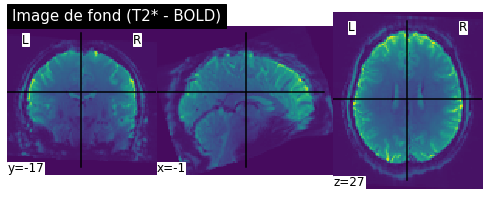

In [7]:
from nilearn import plotting
from nilearn import image

# Concat 3d images
fmri_img = image.concat_imgs(filename)

# Plot mean img
mean_img = image.mean_img(fmri_img)
plotting.plot_img(mean_img, title='Image de fond (T2* - BOLD)')

In [8]:
# Build GLM
from nilearn.glm.first_level import FirstLevelModel
fmri_glm = FirstLevelModel(t_r=1.49,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01)

In [9]:
# Fit
fmri_glm = fmri_glm.fit(fmri_img, LvR_df)

<ipython-input-10-8369d35e769e>:5: UserWarning: 

 | Using Nistats with Nilearn versions >= 0.7.0 is redundant and potentially conflicting.
 | Nilearn versions 0.7.0 and up offer all the functionality of Nistats as well the latest features and fixes.
 | We strongly recommend uninstalling Nistats and using Nilearn's stats & reporting modules.

  from nistats.reporting import plot_design_matrix
<ipython-input-10-8369d35e769e>:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


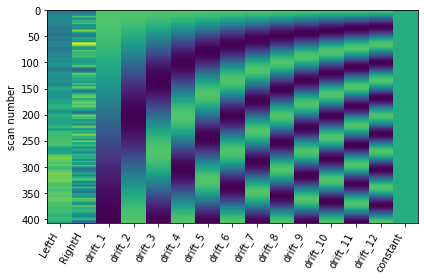

In [10]:
# Create design_matrix
design_matrix = fmri_glm.design_matrices_[0]

# Plot
from nistats.reporting import plot_design_matrix
plot_design_matrix(design_matrix)
plt.show()

<ipython-input-11-645a9cfaba8b>:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


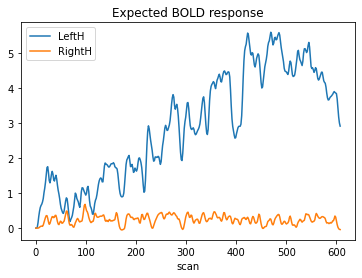

In [11]:
# Plot convoluted regressors
plt.plot(design_matrix['LeftH'], label='LeftH')
plt.plot(design_matrix['RightH'], label='RightH')

plt.xlabel('scan')
plt.title('Expected BOLD response')
plt.legend()
plt.show()

In [12]:
# Create condition arrays
from numpy import array
conditions = {
    'LeftH': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'RightH':   array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
}

In [13]:
# Subtract conditions
left_minus_right = conditions['LeftH'] - conditions['RightH']

/home/hyruuk/anaconda3/envs/hyruuk_shinobi_behav/lib/python3.8/site-packages/nistats/reporting/_plot_matrices.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['' for x in ax.get_yticklabels()])


<AxesSubplot:label='conditions'>

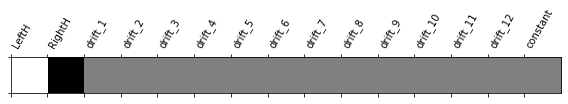

In [14]:
# Plot contrast
from nistats.reporting import plot_contrast_matrix
plot_contrast_matrix(left_minus_right, design_matrix=design_matrix)

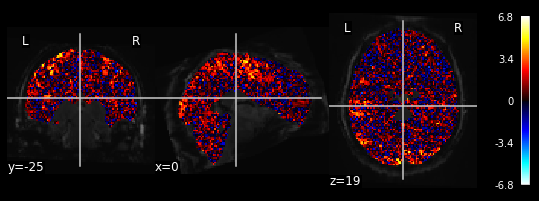

In [23]:
# Z score maps

z_map = fmri_glm.compute_contrast(left_minus_right,
                                    output_type='z_score', stat_type='F')
plotting.plot_stat_map(z_map, bg_img=mean_img)

<ipython-input-24-1dea0c8ac193>:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


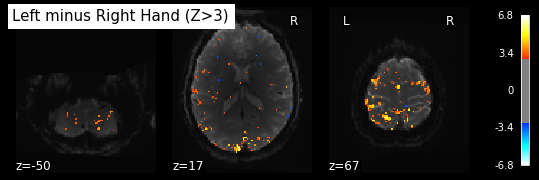

In [24]:
# Z threshold

plotting.plot_stat_map(z_map, bg_img=mean_img, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Left minus Right Hand (Z>3)')
plt.show()

Uncorrected p<0.001 threshold: 3.291


<ipython-input-25-ed2c4c4de0e3>:9: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


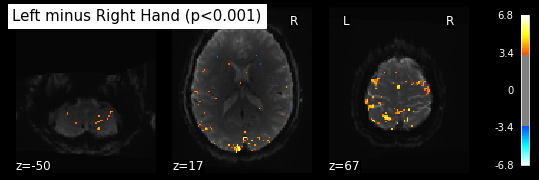

In [25]:
# Uncorrected

from nistats.thresholding import map_threshold
uncorr_001, threshold = map_threshold(z_map, alpha=.001, height_control='fpr')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)
plotting.plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Left minus Right Hand (p<0.001)')
plt.show()

Taux de fausse découverte (FDR) = 0.05 threshold: 3.428


<ipython-input-26-3db6cef7a984>:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


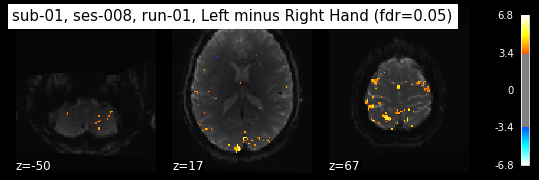

In [26]:
# FDR only

_, threshold = map_threshold(z_map, alpha=.05, height_control='fdr')

print('Taux de fausse découverte (FDR) = 0.05 threshold: %.3f' % threshold)

plotting.plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='sub-01, ses-008, run-01, Left minus Right Hand (fdr=0.05)')
plt.show()

<ipython-input-27-c8010f89040b>:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


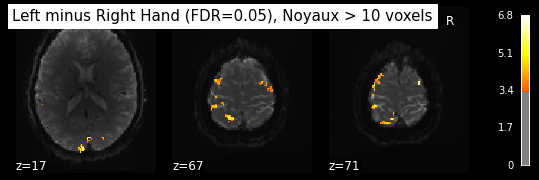

In [27]:
# FDR + clusters

clean_map, threshold = map_threshold(z_map, alpha=.05, height_control='fdr', cluster_threshold=10)

plotting.plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Left minus Right Hand (FDR=0.05), Noyaux > 10 voxels')
plt.show()

In [28]:
# Save interactive plot
view = plotting.view_img(clean_map, threshold=3, title='Left minus Right Hand (FDR=0.05), Noyaux > 10 voxels')
view.save_as_html(figures_path + '/LmR_statsmap.html')

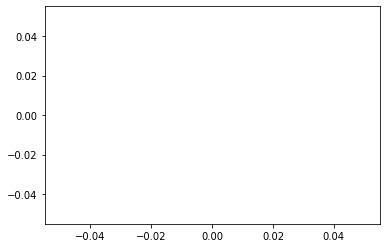

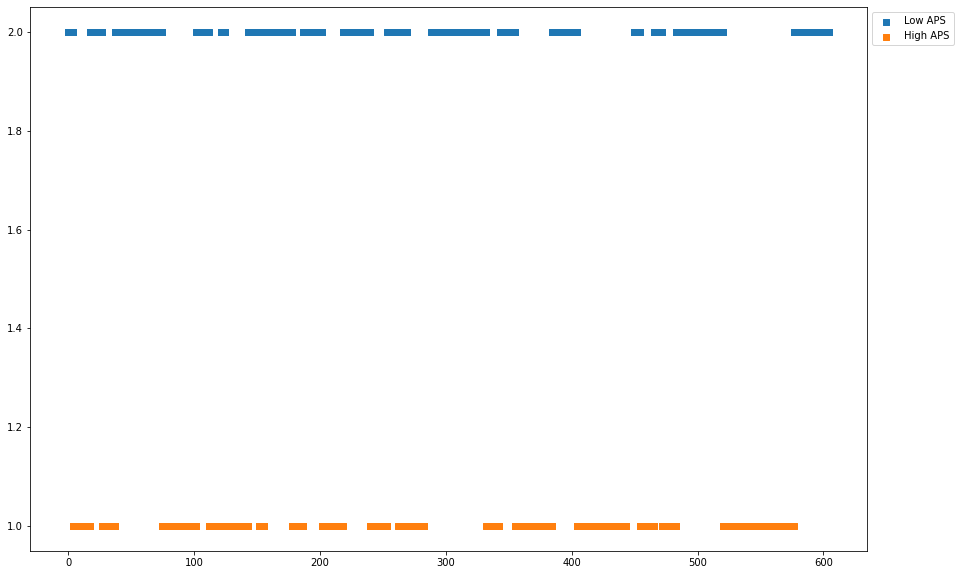

In [21]:
plot_bidsevents(APS_df);